In [1]:
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy as sp

In [2]:
mic_coords = pd.read_excel("data/mic_coords_final.xlsx", index_col=0)
distances = pd.read_excel("data/miscellaneous_positions.xlsx", index_col=0)


def get_mic_coords(name, df, x, y, z):
    filtered_df = df[df['Mic_Index'] == name]
    coordinates = filtered_df[[x, y, z]].to_numpy()
    return coordinates[0]



position_coords_default = []
for name in distances["point 2"]:
    coord = get_mic_coords(name, mic_coords, "X", "Y", "Z")
    position_coords_default.append(coord)
position_coords_default = np.array(position_coords_default)

position_coords_optimized = []
for name in distances["point 2"]:
    coord = get_mic_coords(name, mic_coords, "X_optimized", "Y_optimized", "Z_optimized")
    position_coords_optimized.append(coord)
position_coords_optimized = np.array(position_coords_optimized)

distances_array = distances["distance"].to_numpy()

In [3]:
#from scipy.optimize import least_squares

def trilaterate(ref_points, distances):
    """
    Solves the 3D trilateration problem using least squares optimization.
    
    Parameters:
    - ref_points: List of N (x, y, z) coordinates of reference points (N >= 4)
    - distances: List of N distances from each reference point to the unknown point
    
    Returns:
    - (x, y, z): Estimated coordinates of the unknown point
    """
    
    # Initial guess: Average of reference points
    initial_guess = np.mean(ref_points, axis=0)

    # Function to minimize: Distance equation error for all reference points
    def error_function(unknown):
        return np.linalg.norm(ref_points - unknown, axis=1) - distances

    # Solve using least squares optimization
    result = sp.optimize.least_squares(error_function, initial_guess, method='lm')

    return result.x  # Return the estimated (x, y, z) coordinates

In [4]:
bassoon_low = trilaterate(position_coords_optimized[0:6], distances_array[0:6])
print("bassoon_low xyz:", bassoon_low)

bassoon_high = trilaterate(position_coords_optimized[6:12], distances_array[6:12])
print("bassoon_high xyz:", bassoon_high)

camera_1 = trilaterate(position_coords_optimized[12:18], distances_array[12:18])
print("camera_1 xyz:", camera_1)

camera_2 = trilaterate(position_coords_optimized[18:24], distances_array[18:24])
print("camera_2 xyz:", camera_2)


referecene_speaker = trilaterate(position_coords_optimized[24:29], distances_array[24:29])
print("referecene_speaker xyz:", referecene_speaker)

bassoon_low xyz: [0.97081132 0.98296962 0.41316809]
bassoon_high xyz: [0.53056959 0.3204048  1.48546785]
camera_1 xyz: [1.3236992  0.04429161 0.52348324]
camera_2 xyz: [1.16191888 0.76769209 1.82988376]
referecene_speaker xyz: [0.72439712 0.62713966 0.55611907]


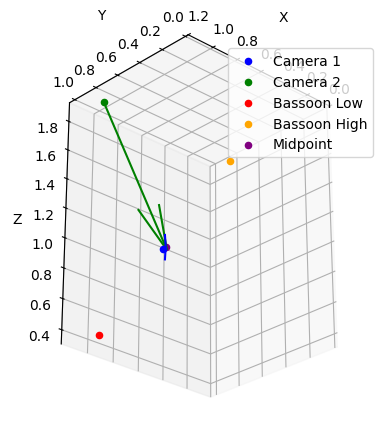

Camera 1 Azimuth: -133.33136452241695
Camera 1 Altitude: -27.020027669675454
Camera 2 Azimuth: 164.2465834869733
Camera 2 Altitude: 64.11592446841624


In [ ]:
# hier werden die Azimuth- und Altitude-Winkel der beiden kameras berechnet


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

midpoint = (bassoon_low + bassoon_high) / 2

directionVectorCamera1 = midpoint - camera_1
directionVectorCamera2 = midpoint - camera_2

Camera1_Azimuth = -np.degrees(np.arctan2(directionVectorCamera1[1], directionVectorCamera1[0]))
Camera1_Altitude = -np.degrees(np.arcsin(directionVectorCamera1[2] / np.linalg.norm(directionVectorCamera1)))

Camera2_Azimuth = -np.degrees(np.arctan2(directionVectorCamera2[1], directionVectorCamera2[0]))
Camera2_Altitude = -np.degrees(np.arcsin(directionVectorCamera2[2] / np.linalg.norm(directionVectorCamera2)))

# Plotten der Vektoren
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotten der Kameras
ax.scatter(camera_1[0], camera_1[1], camera_1[2], color='blue', label='Camera 1')
ax.scatter(camera_2[0], camera_2[1], camera_2[2], color='green', label='Camera 2')

# Plotten der Bassoon-Punkte
ax.scatter(bassoon_low[0], bassoon_low[1], bassoon_low[2], color='red', label='Bassoon Low')
ax.scatter(bassoon_high[0], bassoon_high[1], bassoon_high[2], color='orange', label='Bassoon High')

# Plotten des Mittelpunkts
ax.scatter(midpoint[0], midpoint[1], midpoint[2], color='purple', label='Midpoint')

# Plotten der Richtungsvektoren
ax.quiver(camera_1[0], camera_1[1], camera_1[2], directionVectorCamera1[0], directionVectorCamera1[1], directionVectorCamera1[2], color='blue', length=1, normalize=True)
ax.quiver(camera_2[0], camera_2[1], camera_2[2], directionVectorCamera2[0], directionVectorCamera2[1], directionVectorCamera2[2], color='green', length=1, normalize=True)

# Achsenbeschriftungen
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(1.2, 0)
ax.set_aspect('equal', adjustable='box')

ax.view_init(elev=Camera1_Altitude, azim=Camera1_Azimuth)  # Elevation und Azimutwinkel anpassen


# Legende
ax.legend()

# Anzeigen des Plots
plt.show()


print("Camera 1 Azimuth:", Camera1_Azimuth)
print("Camera 1 Altitude:", Camera1_Altitude)

print("Camera 2 Azimuth:", Camera2_Azimuth)
print("Camera 2 Altitude:", Camera2_Altitude)

In [5]:

fig = px.scatter_3d(mic_coords, x='X_optimized', y='Y_optimized', z='Z_optimized', text='Mic_Index', title='3D Scatter Plot', color='Plane', width=1000, height=1000)


# Add the single point to the existing figure
fig.add_trace(go.Scatter3d(
    x=[bassoon_low[0]],  # x-coordinate of the single point
    y=[bassoon_low[1]],  # y-coordinate of the single point
    z=[bassoon_low[2]],  # z-coordinate of the single point
    mode='markers+text',  # Include markers and optional text
    marker=dict(size=10, color='black'),  # Customize the marker style
    text=['bassoon_low'],  # Optional text label for the point
    name='bassoon_low'  # Legend entry
))

# Add the single point to the existing figure
fig.add_trace(go.Scatter3d(
    x=[bassoon_high[0]],  # x-coordinate of the single point
    y=[bassoon_high[1]],  # y-coordinate of the single point
    z=[bassoon_high[2]],  # z-coordinate of the single point
    mode='markers+text',  # Include markers and optional text
    marker=dict(size=10, color='black'),  # Customize the marker style
    text=['bassoon_high'],  # Optional text label for the point
    name='bassoon_high'  # Legend entry
))

# Add the single point to the existing figure
fig.add_trace(go.Scatter3d(
    x=[camera_1[0]],  # x-coordinate of the single point
    y=[camera_1[1]],  # y-coordinate of the single point
    z=[camera_1[2]],  # z-coordinate of the single point
    mode='markers+text',  # Include markers and optional text
    marker=dict(size=10, color='black'),  # Customize the marker style
    text=['camera_1'],  # Optional text label for the point
    name='camera_1'  # Legend entry
))

# Add the single point to the existing figure
fig.add_trace(go.Scatter3d(
    x=[camera_2[0]],  # x-coordinate of the single point
    y=[camera_2[1]],  # y-coordinate of the single point
    z=[camera_2[2]],  # z-coordinate of the single point
    mode='markers+text',  # Include markers and optional text
    marker=dict(size=10, color='black'),  # Customize the marker style
    text=['camera_2'],  # Optional text label for the point
    name='camera_2'  # Legend entry
))

# Add the single point to the existing figure
fig.add_trace(go.Scatter3d(
    x=[referecene_speaker[0]],  # x-coordinate of the single point
    y=[referecene_speaker[1]],  # y-coordinate of the single point
    z=[referecene_speaker[2]],  # z-coordinate of the single point
    mode='markers+text',  # Include markers and optional text
    marker=dict(size=10, color='black'),  # Customize the marker style
    text=['referecene_speaker'],  # Optional text label for the point
    name='referecene_speaker'  # Legend entry
))

fig.update_layout(scene=dict(
    xaxis=dict(range=[1.5, 0]), # x-Achse umdrehen - "linke hand regel"
))

# Plot anzeigen
fig.show()